# 🚀 Second Challenge Question
In this task you're goinig to implement and train a ResNet model from scratch on images, crawled from DigiKala website and classifiy them into 10 classes.

Please consider the steps and fill *#TODO* sections
Please use just trainset and valdset of following dataset.

[Dataset](https://drive.google.com/drive/folders/1-7x1s7daX-62VWDoKoXZqRs0YxOkrQeQ?usp=sharing)

First add a shortcut of shared dir. to your drive then work with it.

In [3]:
from google.colab import drive

In [4]:
# Step 1: Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder

In [ ]:
# Define transforms for training and validation
# In this transform please apply data augmentation techniques e.g.: RandomResizedCrop to 224, RandomHorizontalFlip, RandomRotation up 10 degrees, ColorJitter, ...
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),          # Randomly resize and crop the image to 224x224
    transforms.RandomHorizontalFlip(),          # Randomly flip the image horizontally
    transforms.RandomRotation(10),              # Randomly rotate the image by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.ToTensor(),                      # Convert the image to a tensor
])

# Decide whether to apply augmentation to the validation transform or not. If not, consider the image spatial consistency between train and val.
val_transform = transforms.Compose([
    transforms.Resize(256),                      # Resize the shorter side of the image to 256 pixels
    transforms.CenterCrop(224),                  # Crop the center 224x224 pixels from the image
    transforms.ToTensor(),                       # Convert the image to a tensor
])

In [ ]:
# Step 2: Define the correct path to your dataset on Google Drive
base_dir = '/content/drive/MyDrive/data/'  # Replace with your actual path

train_dir = os.path.join(base_dir, 'trainset')
valid_dir = os.path.join(base_dir, 'validset')

In [ ]:
# Define train and validation dataset objects with suitable paths and transforms.
trainset = ImageFolder(root=train_dir, transform=train_transform)
validset = ImageFolder(root=valid_dir, transform=val_transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
validloader = DataLoader(validset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# In this section we will build our ResNet architecture.
# We will build the model in a modular approach.
# First, we will define basic blocks of ResNet containing
# Conv and BN layers, activation functions, and residual connections.
# We are targeting implementing ResNet-18 model.
# Stack layers upon each other and finally complete the architecture.


class BasicBlock(nn.Module):
    expansion = 1  # For ResNet-18 and ResNet-34

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        # Define conv1 with input channels and output channels
        # Set the kernel size to 3, padding to 1, stride as provided, and disable the bias term
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # Define the bn1 layer on the output of conv1
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Define ReLU activation function and make it inplace
        self.relu = nn.ReLU(inplace=True)

        # Define conv2 with proper input channels and output channels
        # Set the kernel size to 3, padding to 1, stride to 1, and disable the bias term
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # Define bn2 as same as bn1
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        # Identity is for residual connection
        identity = x

        # If we have downsampled the input of the block, downsample the identity to avoid shape inconsistency
        if self.downsample is not None:
            identity = self.downsample(x)

        # Forward pass through conv1, bn1, and ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Forward pass through conv2 and bn2
        out = self.conv2(out)
        out = self.bn2(out)

        # Add residual connection
        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        '''
        args:
            block: Class of basic block.
            layers: list of numbers of basic blocks in each layer.
            num_classes: size of classifier.
        '''
        super(ResNet, self).__init__()
        self.in_channels = 64
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Define the max pool layer on 2D tensors with kernel size 3, padding 1, and stride 2
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define the residual layers
        # Each layer takes the basic block class, output channel size, number of blocks in that layer, and stride if needed
        self.layer1 = self._make_layer(block, 64, layers[0])    # layer1 with 64 channels
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # layer2 with 128 channels
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # layer3 with 256 channels
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # layer4 with 512 channels

        # Implement adaptive average pooling layer with (1, 1) output size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Define the classifier
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        '''
        This function defines a residual layer.

        args:
            block: basic block class.
            out_channels: output size of blocks.
            blocks: number of blocks in this layer.
            stride: stride in the first block.
        '''
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            # If the input and output channels of a block differ
            # the residual connection should handle this and downsample the
            # identity input to avoid spatial inconsistency.
            # For this, use a sequential of conv2d with proper input and output channels, kernel size of 1,
            # provided stride, and disabled bias term, followed by a BN layer.
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        # Initialize the list of layers
        layers = []
        # Add the first block with downsample and stride
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        # Update the number of input channels for the next blocks
        self.in_channels = out_channels * block.expansion
        # Add the remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        # Return a sequential container of the blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        Our network architecture:
        conv1 -> bn1 -> ReLU -> maxpool -> layer1 -> layer2 -> layer3 -> layer4 -> avgpool -> flatten -> fc
        '''
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = self.fc(x)

        return x


In [ ]:
# part 4 :
# You have to define the model here. Our model has 2 blocks in every layer (1-4)
# Set number of classes w.r.t. dataset.
# Use implemented BasicBlocks
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)  # ResNet-18 architecture with 10 output classes


In [ ]:
# part 5:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_losses.append(val_loss / len(validloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1]:.2f}%, '
          f'Val Acc: {val_accuracies[-1]:.2f}%')


Epoch 1/10, Train Loss: 2.3013, Val Loss: 2.3190, Train Acc: 15.42%, Val Acc: 17.57%
Epoch 2/10, Train Loss: 2.2376, Val Loss: 2.2012, Train Acc: 16.48%, Val Acc: 20.61%
Epoch 3/10, Train Loss: 2.2310, Val Loss: 2.1830, Train Acc: 17.18%, Val Acc: 16.89%
Epoch 4/10, Train Loss: 2.2025, Val Loss: 2.1272, Train Acc: 17.90%, Val Acc: 18.92%
Epoch 5/10, Train Loss: 2.1812, Val Loss: 2.1365, Train Acc: 18.96%, Val Acc: 19.26%
Epoch 6/10, Train Loss: 2.1541, Val Loss: 2.1112, Train Acc: 21.26%, Val Acc: 25.34%
Epoch 7/10, Train Loss: 2.1536, Val Loss: 2.2304, Train Acc: 20.97%, Val Acc: 19.26%
Epoch 8/10, Train Loss: 2.1348, Val Loss: 2.1941, Train Acc: 22.78%, Val Acc: 19.93%
Epoch 9/10, Train Loss: 2.1252, Val Loss: 2.2622, Train Acc: 22.83%, Val Acc: 15.54%
Epoch 10/10, Train Loss: 2.1124, Val Loss: 2.1239, Train Acc: 23.54%, Val Acc: 21.96%


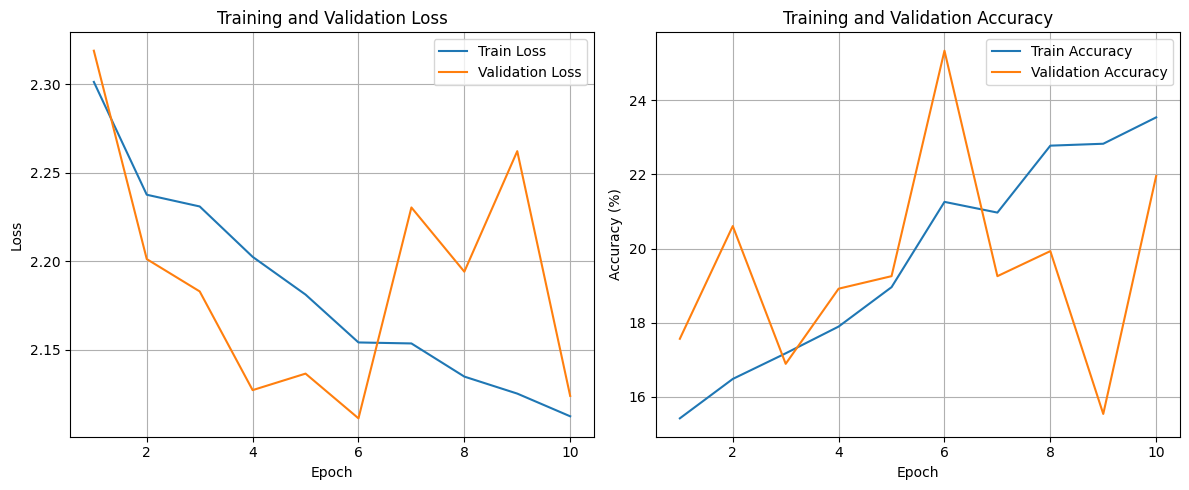

In [ ]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Validation Epoch 1/10: 100%|██████████| 10/10 [00:45<00:00,  4.53s/it]


Epoch 1/10, Train Loss: 2.2447, Val Loss: 2.1720, Train Acc: 16.61%, Val Acc: 17.57%


Validation Epoch 2/10: 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


Epoch 2/10, Train Loss: 2.1978, Val Loss: 2.1761, Train Acc: 19.33%, Val Acc: 15.54%


Validation Epoch 3/10: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Epoch 3/10, Train Loss: 2.1737, Val Loss: 2.2015, Train Acc: 19.87%, Val Acc: 17.23%


Validation Epoch 4/10: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch 4/10, Train Loss: 2.1617, Val Loss: 2.1809, Train Acc: 20.39%, Val Acc: 18.58%


Validation Epoch 5/10: 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


Epoch 5/10, Train Loss: 2.1404, Val Loss: 2.0580, Train Acc: 21.62%, Val Acc: 24.66%


Validation Epoch 6/10: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch 6/10, Train Loss: 2.1234, Val Loss: 2.1887, Train Acc: 22.87%, Val Acc: 19.93%


Validation Epoch 7/10: 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch 7/10, Train Loss: 2.1025, Val Loss: 2.0886, Train Acc: 24.00%, Val Acc: 25.00%


Validation Epoch 8/10: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


Epoch 8/10, Train Loss: 2.0899, Val Loss: 2.0062, Train Acc: 24.14%, Val Acc: 29.39%


Validation Epoch 9/10: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch 9/10, Train Loss: 2.0572, Val Loss: 2.0185, Train Acc: 25.56%, Val Acc: 26.35%


Validation Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch 10/10, Train Loss: 2.0548, Val Loss: 2.0539, Train Acc: 25.41%, Val Acc: 26.35%


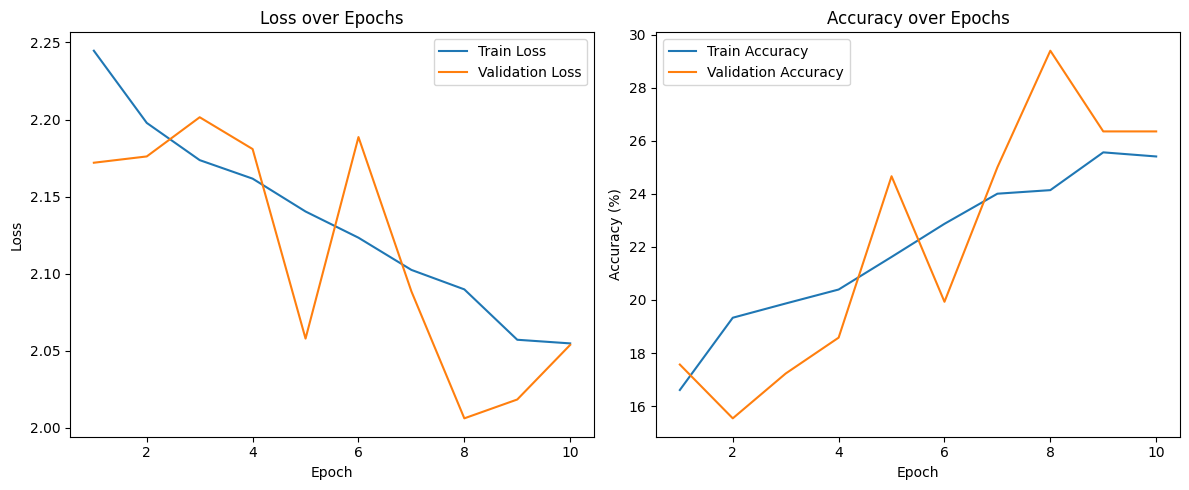

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm  # Import tqdm

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, img_file))
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dir = '/content/drive/MyDrive/data/trainset'
val_dir = '/content/drive/MyDrive/data/validset'

trainset = ImageClassificationDataset(root_dir=train_dir, transform=train_transform)
validset = ImageClassificationDataset(root_dir=val_dir, transform=val_transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=32, shuffle=False, num_workers=2)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    # Wrap the training DataLoader with tqdm for progress tracking
    for images, labels in tqdm(trainloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0

    # Wrap the validation DataLoader with tqdm for progress tracking
    with torch.no_grad():
        for images, labels in tqdm(validloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(validloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1]:.2f}%, '
          f'Val Acc: {val_accuracies[-1]:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


<h1>Version 3</h1>

Validation Epoch 1/30: 100%|██████████| 10/10 [00:49<00:00,  4.98s/it]


Epoch 1/30, Train Loss: 2.2480, Val Loss: 2.4216, Train Acc: 16.24%, Val Acc: 13.51%


Validation Epoch 2/30: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch 2/30, Train Loss: 2.1926, Val Loss: 2.2401, Train Acc: 19.18%, Val Acc: 13.51%


Validation Epoch 3/30: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Epoch 3/30, Train Loss: 2.1660, Val Loss: 2.1473, Train Acc: 20.55%, Val Acc: 23.99%


Validation Epoch 4/30: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch 4/30, Train Loss: 2.1472, Val Loss: 2.0878, Train Acc: 21.15%, Val Acc: 24.66%


Validation Epoch 5/30: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch 5/30, Train Loss: 2.1323, Val Loss: 2.0980, Train Acc: 21.75%, Val Acc: 22.64%


Validation Epoch 6/30: 100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Epoch 6/30, Train Loss: 2.1148, Val Loss: 2.0899, Train Acc: 23.00%, Val Acc: 23.65%


Validation Epoch 7/30: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Epoch 7/30, Train Loss: 2.1010, Val Loss: 2.0998, Train Acc: 24.08%, Val Acc: 24.66%


Validation Epoch 8/30: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch 8/30, Train Loss: 2.0906, Val Loss: 2.2624, Train Acc: 24.25%, Val Acc: 15.88%


Validation Epoch 9/30: 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Epoch 9/30, Train Loss: 2.0793, Val Loss: 2.2884, Train Acc: 24.44%, Val Acc: 17.91%


Validation Epoch 10/30: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s]


Epoch 10/30, Train Loss: 2.0582, Val Loss: 2.5085, Train Acc: 25.67%, Val Acc: 10.14%


Validation Epoch 11/30: 100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Epoch 11/30, Train Loss: 2.0447, Val Loss: 2.3875, Train Acc: 26.13%, Val Acc: 18.92%


Validation Epoch 12/30: 100%|██████████| 10/10 [00:02<00:00,  4.89it/s]


Epoch 12/30, Train Loss: 2.0239, Val Loss: 1.9347, Train Acc: 27.21%, Val Acc: 31.76%


Validation Epoch 13/30: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


Epoch 13/30, Train Loss: 2.0154, Val Loss: 2.3303, Train Acc: 27.90%, Val Acc: 18.24%


Validation Epoch 14/30: 100%|██████████| 10/10 [00:02<00:00,  4.56it/s]


Epoch 14/30, Train Loss: 2.0087, Val Loss: 1.9399, Train Acc: 27.85%, Val Acc: 30.74%


Validation Epoch 15/30: 100%|██████████| 10/10 [00:02<00:00,  4.96it/s]


Epoch 15/30, Train Loss: 1.9864, Val Loss: 2.3400, Train Acc: 28.84%, Val Acc: 19.59%


Validation Epoch 16/30: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Epoch 16/30, Train Loss: 1.9743, Val Loss: 2.0275, Train Acc: 29.87%, Val Acc: 26.35%


Validation Epoch 17/30: 100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Epoch 17/30, Train Loss: 1.9577, Val Loss: 2.3369, Train Acc: 30.34%, Val Acc: 20.61%


Validation Epoch 18/30: 100%|██████████| 10/10 [00:02<00:00,  4.69it/s]


Epoch 18/30, Train Loss: 1.9450, Val Loss: 2.1214, Train Acc: 31.44%, Val Acc: 22.30%


Validation Epoch 19/30: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Epoch 19/30, Train Loss: 1.9252, Val Loss: 2.4890, Train Acc: 31.28%, Val Acc: 17.57%


Validation Epoch 20/30: 100%|██████████| 10/10 [00:02<00:00,  4.42it/s]


Epoch 20/30, Train Loss: 1.9181, Val Loss: 2.3928, Train Acc: 32.20%, Val Acc: 18.92%


Validation Epoch 21/30: 100%|██████████| 10/10 [00:02<00:00,  4.66it/s]


Epoch 21/30, Train Loss: 1.9098, Val Loss: 1.8083, Train Acc: 31.78%, Val Acc: 36.15%


Validation Epoch 22/30: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Epoch 22/30, Train Loss: 1.8952, Val Loss: 2.1366, Train Acc: 33.30%, Val Acc: 25.68%


Validation Epoch 23/30: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Epoch 23/30, Train Loss: 1.8876, Val Loss: 1.7765, Train Acc: 32.91%, Val Acc: 36.82%


Validation Epoch 24/30: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s]


Epoch 24/30, Train Loss: 1.8653, Val Loss: 2.1677, Train Acc: 34.06%, Val Acc: 27.03%


Validation Epoch 25/30: 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Epoch 25/30, Train Loss: 1.8583, Val Loss: 1.9664, Train Acc: 34.50%, Val Acc: 30.41%


Validation Epoch 26/30: 100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


Epoch 26/30, Train Loss: 1.8388, Val Loss: 1.9217, Train Acc: 35.02%, Val Acc: 29.39%


Validation Epoch 27/30: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Epoch 27/30, Train Loss: 1.8339, Val Loss: 2.2898, Train Acc: 34.66%, Val Acc: 20.95%


Validation Epoch 28/30: 100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Epoch 28/30, Train Loss: 1.8212, Val Loss: 1.7094, Train Acc: 35.71%, Val Acc: 39.19%


Validation Epoch 29/30: 100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Epoch 29/30, Train Loss: 1.8064, Val Loss: 1.8393, Train Acc: 36.88%, Val Acc: 33.78%


Validation Epoch 30/30: 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Epoch 30/30, Train Loss: 1.8031, Val Loss: 2.0461, Train Acc: 36.27%, Val Acc: 28.04%


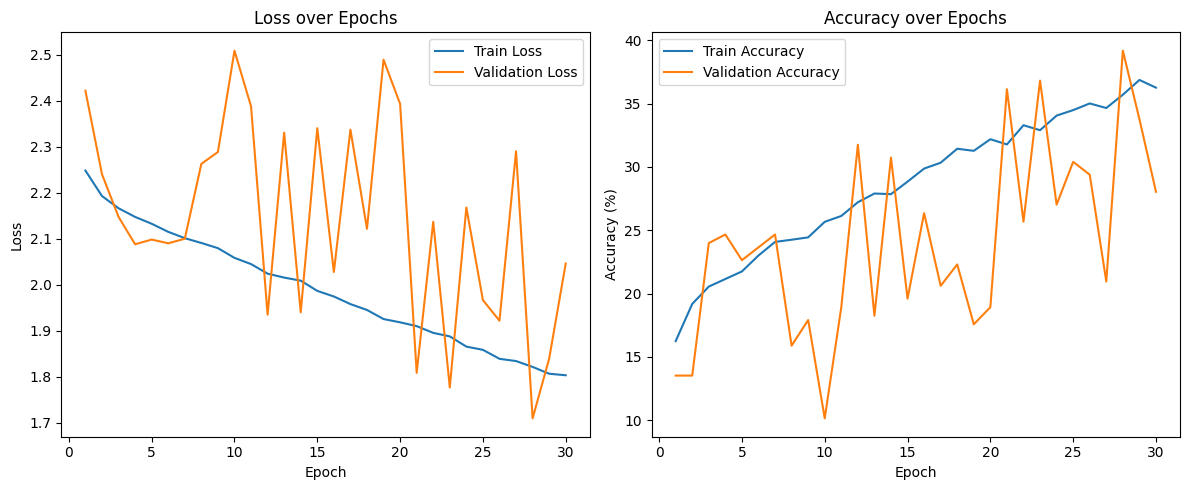

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm  # Import tqdm

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_idx, label in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, label)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(class_dir, img_file))
                        self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dir = '/content/drive/MyDrive/data/trainset'
val_dir = '/content/drive/MyDrive/data/validset'

trainset = ImageClassificationDataset(root_dir=train_dir, transform=train_transform)
validset = ImageClassificationDataset(root_dir=val_dir, transform=val_transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=32, shuffle=False, num_workers=2)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    # Wrap the training DataLoader with tqdm for progress tracking
    for images, labels in tqdm(trainloader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0

    # Wrap the validation DataLoader with tqdm for progress tracking
    with torch.no_grad():
        for images, labels in tqdm(validloader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(validloader))
    val_accuracies.append(100 * correct / total)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1]:.2f}%, '
          f'Val Acc: {val_accuracies[-1]:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
